# Forecasting Lorenz System using Encoder-Decoder Seq2seq Architecture
Jun 14, 2019. Guorui Shen, guorui233@outlook.com.

- RNN adopted in this notebook is built on Tensorflow.

**Data information**
+ Time series considered in this demo is $u_i = \left[x(t_i), y(t_i), z(t_i)\right]$, sampled from Lorenz system
\begin{align}
&\frac{dx}{dt}=\sigma(y-x),\\
&\frac{dy}{dt}=x(\rho-z)-y,\\
&\frac{dz}{dt}=xy-\beta z.
\end{align}
+ Neural Network (NN) we used in here contains an encoder and a decoder. Features and labels are chosen such that
$$NN(u_k, u_{k+1}, \cdots, u_{k+\text{encoder_maxtime}-1}) = u_{k+1}, u_{k+2}, \cdots, u_{k+\text{encoder_maxtime}}$$
i.e. NN maps from past observations to future one-step-shift  observations.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [2]:
tfseed = 36
npseed = 1

np.random.seed(npseed)

## 1 Original data

In [3]:
num_discard = 2000
lrz = sio.loadmat('Lorenz.mat')
data = lrz['states'][num_discard:,:]
T = lrz['t'][0][num_discard:]
print(len(data), len(data[0]))

(4000, 3)


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,u't')

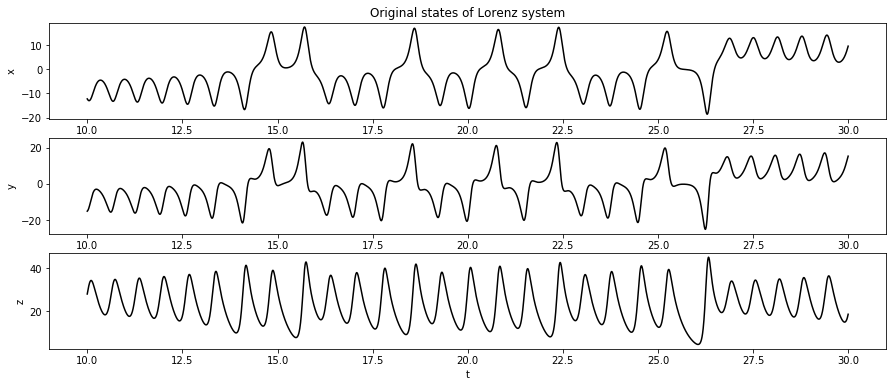

In [4]:
ylabel = ['x', 'y', 'z']
plt.figure(figsize=(15, 6))
plt.subplot(311)
plt.title('Original states of Lorenz system')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(T, data[:, i], 'k-')
    plt.ylabel(ylabel[i])
plt.xlabel('t')

## 2 Pick up needed features and labels

In [5]:
batch_size = 200
num_train = 2200 # number of examples for training
num_test = 700
decoder_maxtime = encoder_maxtime = 12

# Internal neural network parameters
num_hidden_nodes = 100
out_dim = in_dim = 3
GO = np.ones((1, in_dim))

### Data for training model

In [6]:
# features and labels for training model
in_encoder_train = np.empty(shape=(0, encoder_maxtime, in_dim))
in_decoder_train = np.empty(shape=(0, decoder_maxtime, in_dim))
out_train = np.empty(shape=(0, decoder_maxtime, out_dim))
for i in range(num_train):
    in_encoder_train = np.vstack((in_encoder_train, data[i:i+encoder_maxtime, :].reshape(-1,encoder_maxtime,in_dim)))
    
    temp = np.vstack((np.zeros((1, in_dim)), data[i+1:i+decoder_maxtime, :]))
    in_decoder_train = np.vstack((in_decoder_train, temp.reshape(-1,decoder_maxtime,in_dim)))
    
    out_train = np.vstack((out_train, data[i+1:i+1+decoder_maxtime, :].reshape(-1,decoder_maxtime,out_dim)))
print(in_encoder_train.shape, in_decoder_train.shape, out_train.shape)

((2200, 12, 3), (2200, 12, 3), (2200, 12, 3))


### Data for testing model

In [7]:
# features and labels for testing model
i = num_train
in_encoder_test = data[i:i+encoder_maxtime, :].reshape(-1, encoder_maxtime, in_dim)

temp = np.vstack((GO, data[i+1:i+decoder_maxtime, :]))
in_decoder_test = temp.reshape(-1, decoder_maxtime, in_dim)

out_test = data[i+encoder_maxtime:i+encoder_maxtime+num_test, :]
print(in_encoder_test.shape, in_decoder_test.shape, out_test.shape)

# for plotting
T_train = T[:i+encoder_maxtime]
T_test = T[i+encoder_maxtime:i+encoder_maxtime+num_test]

((1, 12, 3), (1, 12, 3), (700, 3))


## 3 Define the seq2seq neural network

<img src="https://suzyi.github.io/images/basic_seq2seq.png" />

Comparatively to what we see in the image, our neural network deals with signal rather than letters. Also, we don't have the feedback mechanism yet. 

In [8]:
# Optmizer
learning_rate = 0.007  # Small lr helps not to diverge during training. 
num_iter = 2000  # How many times we perform a training step (therefore how many times we show a batch). 

In [9]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [10]:
tf.set_random_seed(tfseed)

### Encoder

In [11]:
encoder_inputs = tf.placeholder(tf.float32, shape=(None, encoder_maxtime, in_dim), name="encoder_inputs")
encoder_cell = tf.nn.rnn_cell.LSTMCell(num_units=num_hidden_nodes)
encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    cell=encoder_cell, inputs=encoder_inputs, dtype=tf.float32, time_major=False, scope="encoder_rnn")

del encoder_outputs

### Decoder

In [12]:
decoder_inputs = tf.placeholder(tf.float32, shape=(None, decoder_maxtime, in_dim), name="decoder_inputs")
decoder_cell = tf.nn.rnn_cell.LSTMCell(num_units=num_hidden_nodes)
decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    cell=decoder_cell, inputs=decoder_inputs, initial_state=encoder_final_state ,dtype=tf.float32, time_major=False, scope="decoder")

del decoder_final_state

decoder_targets = tf.placeholder(shape=(None, decoder_maxtime, out_dim), dtype=tf.float32, name="decoder_targets")

In [13]:
# units: Integer, dimensionality of the output space.
predictor = tf.layers.dense(inputs=decoder_outputs, units=3, activation=None)

loss_op = tf.reduce_mean(tf.square(tf.subtract(predictor, decoder_targets)))
train_op = tf.train.AdamOptimizer().minimize(loss_op)

## 4 Train the neural network

In [14]:
def next_batch(x, y, z, batch_size):
    N = x.shape[0]
    batch_indices = np.random.permutation(N)[:batch_size]
    return x[batch_indices], y[batch_indices], z[batch_indices]

# Training
train_losses = []
sess.run(tf.global_variables_initializer())
for t in range(0, num_iter+1):

    # both batch_features_tmp and batch_labels_tmp are of the shape: (batch_size, timesteps, output_dim)
    in_encoder_batch, in_decoder_batch, out_decoder_batch = next_batch(
        in_encoder_train, in_encoder_train, out_train, batch_size)
    
    fd = {encoder_inputs: in_encoder_batch, decoder_inputs: in_decoder_batch, decoder_targets: out_decoder_batch}
    _, loss_val = sess.run([train_op, loss_op], feed_dict=fd)
    
    train_losses.append(loss_val)
    if t%500==0:
        print("Training step {}, loss is {:.4f}".format(t, loss_val))
print('Training process finished!')

Training step 0, loss is 260.7283
Training step 500, loss is 4.0577
Training step 1000, loss is 0.3734
Training step 1500, loss is 0.0442
Training step 2000, loss is 0.0092
Training process finished!


Text(0.5,0,u'iteration times')

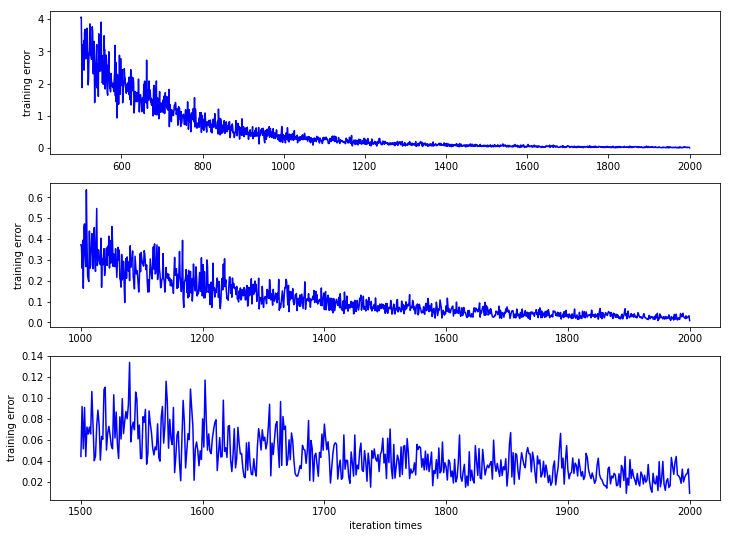

In [15]:
plt.figure(figsize=(12,9))
for i in range(3):
    plt.subplot(311+i)
    plt.plot(range(500*(i+1), num_iter+1), train_losses[500*(i+1):], 'b-')
    plt.ylabel('training error')
plt.xlabel('iteration times')

## 5 Predict future values

In [16]:
results = np.empty((0,out_dim))
for t in range(num_test):
    fd = {encoder_inputs: in_encoder_test, decoder_inputs: in_encoder_test}
    prediction = sess.run(predictor, feed_dict=fd)
    results = np.vstack((results, prediction[0, -1, :]))
    
    in_encoder_test = np.vstack((in_encoder_test[0, 1:, :], results[-1, :])).reshape(-1, encoder_maxtime, in_dim)
    
    temp = np.vstack((GO, in_encoder_test[0, 1:, :]))
    in_decoder_test = temp.reshape(-1, decoder_maxtime, in_dim)
    
print(results.shape)
print(out_test.shape)
predict_error = np.square(np.subtract(out_test, results)).mean()
print('Mean Square Error of {}-step-ahead prediction is {}'.format(num_test, predict_error))

(700, 3)
(700, 3)
Mean Square Error of 700-step-ahead prediction is 38.1895986383


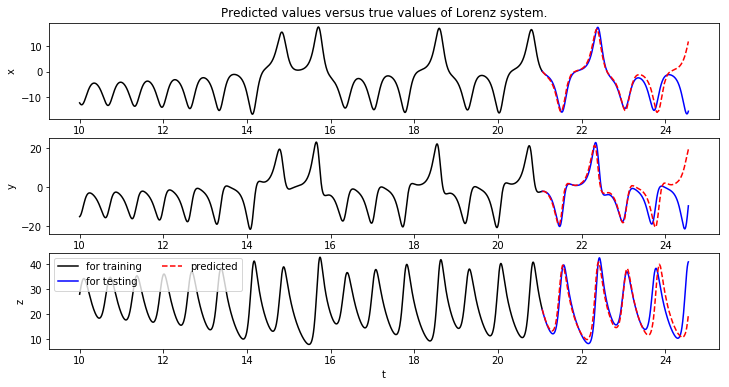

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(311)
plt.title('Predicted values versus true values of Lorenz system.')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(T_train, data[:num_train+encoder_maxtime, i], 'k-', \
             T_test, out_test[:,i], 'b-', T_test, results[:,i], 'r--')
    plt.ylabel(ylabel[i])
plt.xlabel('t')
plt.legend(["for training","for testing", "predicted"], loc = 0, ncol = 2)

In [18]:
# sess.close()

In [19]:
f = open('training-log.csv','a')
# f.write("encoder_maxtime, decoder_maxtime, num_hidden_nodes, num_discard, num_train, num_test, tfseed, npseed, batch_size, num_iter, predict_error\n")
f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {:2f}\n".
        format(encoder_maxtime, decoder_maxtime, num_hidden_nodes, num_discard, num_train, num_test, tfseed, npseed, batch_size, num_iter, predict_error))
f.close()